In [3]:
import torch
import torch.nn as nn
import sys
sys.path.append('..')
import myd2l

In [4]:
class AttentionDecodr(myd2l.Decoder):
    def __init__(self, **kwargs):
        super(AttentionDecodr, self).__init__(**kwargs)
    
    @property
    def attention_weights(self):
        raise NotImplementedError

In [5]:
class Seq2SeqAttentionDecoder(AttentionDecodr):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = myd2l.AdditiveAttention(key_size=num_hiddens, query_size=num_hiddens, num_hiddens=num_hiddens, dropout=dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs.shape: (batch_size, num_steps, num_hiddens)
        # hidden_state.shape: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # X.shape: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        
        outputs, self._attention_weights = [], []
        # x.shape: (batch_size, embed_size) 
        for x in X:
            # query.shape: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context.shape: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # x.shape: (batch_size, 1, embed_size + num_hiddens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # out.shape: (1, batch_size, num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # outputs.shape: (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))

        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [6]:
encoder = myd2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()

X = torch.zeros((4, 7), dtype=torch.long) # (batch_size, num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

epoch 1, loss 2.4158
epoch 10, loss 1.3096
epoch 20, loss 0.9094
epoch 30, loss 0.6663
epoch 40, loss 0.4999
epoch 50, loss 0.3895
epoch 60, loss 0.3168
epoch 70, loss 0.2672
epoch 80, loss 0.2287
epoch 90, loss 0.2068
epoch 100, loss 0.1855
epoch 110, loss 0.1702
epoch 120, loss 0.1559
epoch 130, loss 0.1430
epoch 140, loss 0.1387
epoch 150, loss 0.1279
epoch 160, loss 0.1202
epoch 170, loss 0.1172
epoch 180, loss 0.1107
epoch 190, loss 0.1052
epoch 200, loss 0.1047
epoch 210, loss 0.1030
epoch 220, loss 0.0985
epoch 230, loss 0.0977
epoch 240, loss 0.0962
epoch 250, loss 0.0934


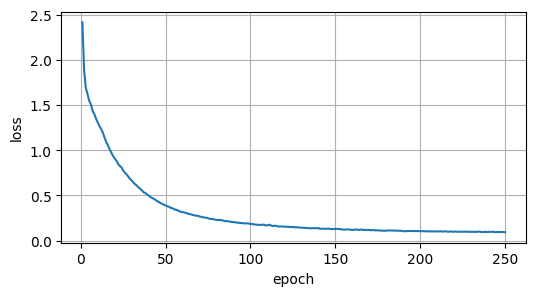

loss 0.0934, 8225.2 tokens/sec on cuda


In [10]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, torch.device('cuda')

train_iter, src_vocab, tgt_vocab = myd2l.load_data_nmt(batch_size, num_steps)
encoder = myd2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = myd2l.EncoderDecoder(encoder, decoder)
myd2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [13]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = myd2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ', f'bleu {myd2l.bleu(translation, fra, k=2):.3f}')


go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => oh non !,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000


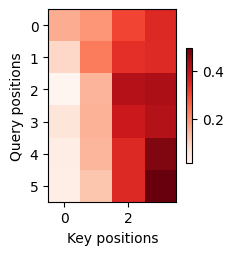

In [14]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((1, 1, -1, num_steps))
myd2l.show_heatmaps(attention_weights[:, :, :, : len(engs[-1].split()) + 1].cpu(), xlabel='Key positions', ylabel='Query positions')